<a href="https://colab.research.google.com/github/DannyData1419/classification/blob/main/Supervised_ML_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Supervised ML Classification

###Import libraries

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier as MLP
from sklearn import metrics

# when using MLP classifier
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Classification report and confusion matrix function

In [ ]:
# classification report and confusion matrix function
def clasif_report_and_conf_matrix(x, y, classifier, label_mapping):
    """
    Performs stratified 5-fold cross-validation on the provided data and returns a classification report
    and the averaged confusion matrix.

    Parameters:
    x (DataFrame): The input features.
    y (Series/array): The target labels.
    label_mapping (dict): A dictionary mapping numerical labels to their corresponding text labels.

    Returns:
    tuple: A classification report (str) from the final fold and an averaged confusion matrix (ndarray).
    """
    kf = StratifiedKFold(n_splits=5)
    confusn_matrices = []
    clasif_reports = []
    for train, test in kf.split(x, y):
        x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y[train], y[test]
        classifier.fit(x_train, y_train)
        predictions = classifier.predict(x_test)
        y_test_text = [label_mapping[label] for label in y_test]
        pred_text = [label_mapping[label] for label in predictions]
        clasif_report = classification_report(pred_text, y_test_text)
        confusn_matrix_fold = confusion_matrix(y_test_text, pred_text, labels=list(label_mapping.values()))
        confusn_matrices.append(confusn_matrix_fold)
    confusn_matrix = np.mean(confusn_matrices, axis=0)
    return clasif_report, confusn_matrix


###Import data

In [ ]:
# load testing data
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

# check for unique class names before mapping
print(iris['class'].unique())

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [ ]:
# map class names to numeric values
iris['class'] = iris['class'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})

# check for unique values after mapping
print(iris['class'].unique())

[0 1 2]


In [ ]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


###Split data into features and target

In [ ]:
x = iris.drop('class', axis=1)
y = iris['class']

###Run experiment

MLP on Iris data experiment # 1
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        10
  Versicolor       1.00      1.00      1.00        10
   Virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



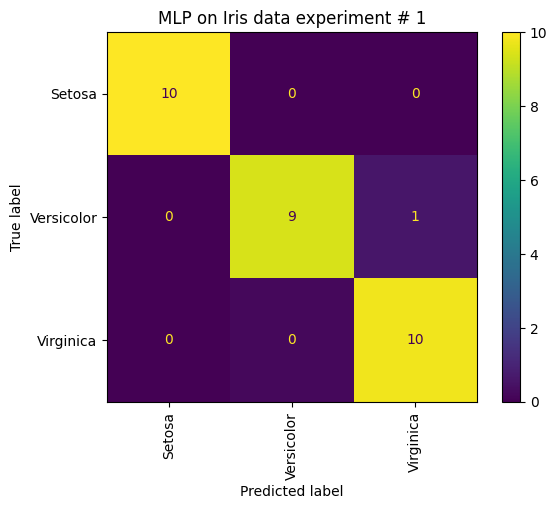

In [ ]:
# global variables
data_desc = 'Iris data'

# label mapping
label_mapping = {0:'Setosa', 1:'Versicolor', 2:'Virginica'}

# local variables/experiment details
experiment_num = '1'
model_type = 'MLP'
classifier = MLP(random_state=8, max_iter=300)

# run function
clasif_report, conf_matrix = clasif_report_and_conf_matrix(x, y, classifier, label_mapping)

# print metrics
print(60*'=')
print(f'{model_type} on {data_desc} experiment # {experiment_num}')
print(60*'=')
print(clasif_report)

display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels=list(label_mapping.values()))
display.plot(values_format='.0f')
plt.xticks(rotation=90)
plt.title(f'{model_type} on {data_desc} experiment # {experiment_num}') ; plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

def plot_roc_curve_with_cv(x, y, classifier, label_mapping):
    """
    Performs stratified 5-fold cross-validation on the provided data and plots the ROC curve for each fold.
    Also returns the mean AUC score across all folds.

    Parameters:
    x (DataFrame): The input features.
    y (Series/array): The target labels.
    classifier (sklearn estimator): The classifier to be used.
    label_mapping (dict): A dictionary mapping numerical labels to their corresponding text labels.

    Returns:
    float: Mean AUC score across all folds.
    """
    kf = StratifiedKFold(n_splits=5)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(7, 5))

    for i, (train, test) in enumerate(kf.split(x, y)):
        x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y[train], y[test]
        classifier.fit(x_train, y_train)
        probas_ = classifier.predict_proba(x_test)

        # We assume binary classification; hence using probas_[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1], pos_label=list(label_mapping.keys())[1])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='b',
             label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=0.8)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with Stratified 5-Fold Cross Validation')
    plt.legend(loc="lower right")
    plt.show()

    return mean_auc


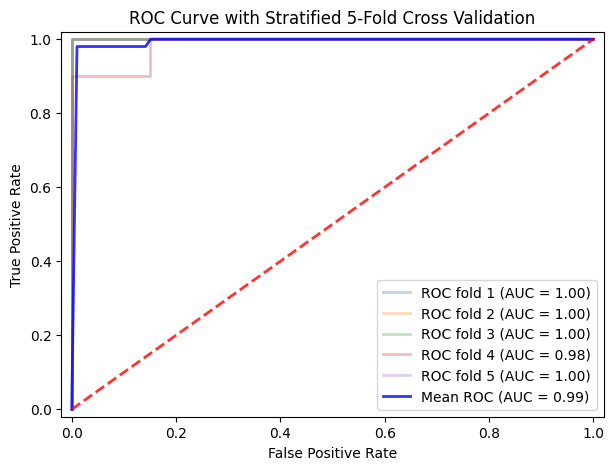

Mean AUC: 0.99


In [ ]:
mean_auc = plot_roc_curve_with_cv(x, y, classifier, label_mapping)
print(f'Mean AUC: {mean_auc:.2f}')
